# Homonyms Problem Solve Using Transformers <br>by **Mohammed Aly**
- [LinkedIn](https://www.linkedin.com/in/mohammed-aly-1854a020a/)  
- [GitHub](https://github.com/MohammedAly22/)

<html>
<img src="https://grammarparty.files.wordpress.com/2020/06/bat.png" width="100%">
</html>

**Homonyms** are words that share the same spelling or form (characters) but possess distinct meanings. For instance, the term **"bank"** can assume two disparate contexts, denoting both a **"financial institution"** and the **"edge of a river."**

These homonyms hold significant relevance in **sentiment analysis**, given their capacity to alter the meaning or emotional tone of a sentence entirely. Consider the following examples that highlight this challenge:

- Sentence 1: "I **hate** the selfishness in you"** => Label: "**NEGATIVE**"
- Sentence 2: "I **hate** anyone who hurts you" => Label: "**POSITIVE**"

In the first sentence, the word "hate" renders the sentiment as `NEGATIVE`. Conversely, the same word, "hate" appears in the second sentence, shaping the sentiment of the sentence as `POSITIVE`. This poses a considerable challenge to models relying on **fixed word embeddings**. Therefore, employing **contextualized embeddings** leveraging attention mechanisms from transformers becomes crucial to grasp the comprehensive context within a sentence.

In this notebook, I will try to demonstrate the impact and the difference between using fixed embeddings and contextualized embeddings.

# 1.0 Installing & Importing Required Packages

In [ ]:
!pip install transformers
!pip install datasets==2.13.1
!pip install fsspec==2023.9.2

In [ ]:
import datasets; datasets.__version__

'2.13.1'

In [ ]:
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2.0 Loading and Exploring the Dataset
[The Stanford Sentiment Treebank (SST)](https://huggingface.co/datasets/sst2) is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

In [ ]:
dataset = load_dataset("sst2")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/sst2-1151590ea3b3f98b/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


## 2.1 Displaying the First 3 Sentences

In [ ]:
print(f"The first 3 examples: ")
dataset["train"][:3]

The first 3 examples: 


{'idx': [0, 1, 2],
 'sentence': ['hide new secretions from the parental units ',
  'contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature '],
 'label': [0, 0, 1]}

## 2.2 Displaying Dataset Features

In [ ]:
print(f"Dataset features: ")
dataset["train"].features

Dataset features: 


{'idx': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

## 2.3 Extract the `label` Feature
As we cann see, `label` features is an instance of `ClassLabel` class which is a useful class from `HuggingFace Datasets` contains the classes names along with methods for converting **from integers to classes and vice versa**.

In [ ]:
labels = dataset["train"].features["label"]
print(f"labels: {labels}")

labels: ClassLabel(names=['negative', 'positive'], id=None)


# 3.0 Preparing and Exploring the Dataset

## 3.1 Adding `label_str` Column to the Dataset

In [ ]:
def convert_id_to_label(example):
    """
    Convert the label ID to its corresponding class.

    Parameters
    ----------
    - example : dict
        Representing one sample of the data.

    Returns
    -------
    - dict
        Contains the new column name `label_str` with corresponding
        class name for eachs sample.
    """
    
    # here we can use the above `labels` object's `in2str()` method
    return {"label_str": labels.int2str(example["label"])}

In [ ]:
dataset["train"] = dataset["train"].map(convert_id_to_label, batched=True)
dataset["validation"] = dataset["validation"].map(convert_id_to_label, batched=True)
print(dataset)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


After the above step, our training and validation datasets contain a new column `label_str` that contains each sample's corresponding class

In [ ]:
print(f"The first example after adding label_str: ")
dataset["train"][0]

The first example after adding label_str: 


{'idx': 0,
 'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'label_str': 'negative'}

## 3.2 Converting the Dataset Format to `Pandas DataFrame`
Although Hugging Face have a useful methods for data visualization, I prefer using pandas due its friendly API.

In [ ]:
dataset.set_format("pandas")
df_train = dataset["train"][:]
df_train.to_csv("/kaggle/input/sst-dataset/df_train.csv")

In [ ]:
df_validation = dataset["validation"][:]
df_validation.to_csv("/kaggle/input/sst-dataset/df_valid.csv")

## 3.3 Loading the Saved CSV Files

In [ ]:
df_train = pd.read_csv("/kaggle/input/sst-dataset/df_train.csv", index_col=0)
df_validation = pd.read_csv("/kaggle/input/sst-dataset/df_valid.csv", index_col=0)

In [ ]:
df_train.head()

,idx,sentence,label,label_str
0,0,hide new secretions from the parental units,0,negative
1,1,"contains no wit , only labored gags",0,negative
2,2,that loves its characters and communicates som...,1,positive
3,3,remains utterly satisfied to remain the same t...,0,negative
4,4,on the worst revenge-of-the-nerds clichés the ...,0,negative


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67349 entries, 0 to 67348
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idx        67349 non-null  int64 
 1   sentence   67349 non-null  object
 2   label      67349 non-null  int64 
 3   label_str  67349 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


## 3.4 Checking Class Imbalance

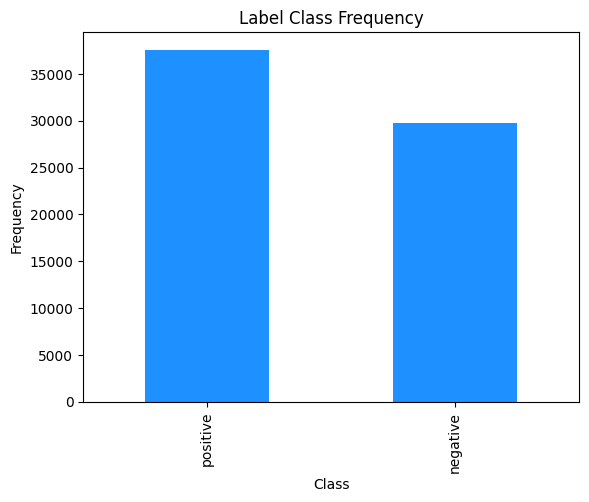

In [ ]:
df_train["label_str"].value_counts().plot.bar(color="dodgerblue")
plt.title("Label Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Observing a slight class imbalance, I plan to train two LSTM models – one before addressing this imbalance and another after making adjustments. This approach aims to evaluate and understand the impact of resolving the class imbalance on the final performance of the model.

## 3.5 Checking the Maximum Words Per Sentence
The importance of this step is summarized due to the limited context window of transformer model (will train them later in the notebook). So, I made this step to be able to see whether there is a sentence is larger than 512 token ot not.

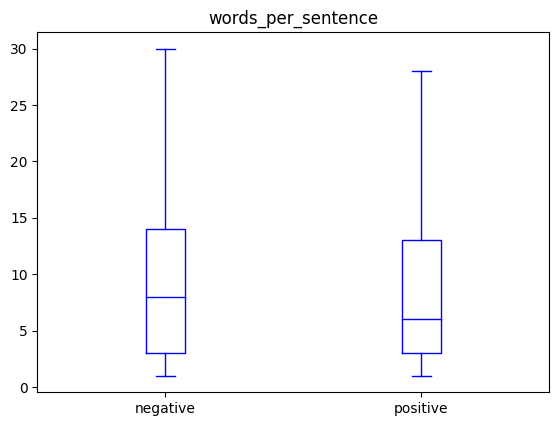

In [ ]:
df_train["words_per_sentence"] = df_train["sentence"].str.split().apply(len)
df_train.boxplot("words_per_sentence", by="label_str", color="blue", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

## 3.6 Converting Text to Integers

In [ ]:
# Instantiate a `tokenizer` object to convert text to integers
tokenizer = Tokenizer()
# Fittng the tokenizer on the training data
tokenizer.fit_on_texts(df_train['sentence'])

# Use the tokenizer to convert sentences to integers
train_sequences = tokenizer.texts_to_sequences(df_train['sentence'])
valid_sequences = tokenizer.texts_to_sequences(df_validation['sentence'])

In [ ]:
word2idx = tokenizer.word_index
# The reason for adding one to be able to map the [padding token]
vocab_size = len(word2idx) + 1
print(f"Total vocab size: {vocab_size}")

Total vocab size: 13823


## 3.7 Padding the Sequences to Maximum Sentence Length

In [ ]:
max_train_sequence_length = max(len(seq) for seq in train_sequences)
max_valid_sequence_length = max(len(seq) for seq in valid_sequences)

print(f"Maximum number of words in training data: {max_train_sequence_length}")
print(f"Maximum number of words in validation data: {max_valid_sequence_length}")

max_sequence_length = max(max_train_sequence_length, max_valid_sequence_length)
print(f"Maximum sequence length: {max_sequence_length}")

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_sequence_length, padding='post')

print(f"Train padded sequence shape: {train_padded_sequences.shape}")
print(f"Validation padded sequence shape: {valid_padded_sequences.shape}")

Maximum number of words in training data: 49
Maximum number of words in validation data: 43
Maximum sequence length: 49
Train padded sequence shape: (67349, 49)
Validation padded sequence shape: (872, 49)


# 4.0 Models Building


## 4.1 Fixed-Embeddings LSTM Base Model (Imbalance)

In [ ]:
# Define multiple values to do a simple grid search
embedding_dims = [64, 128, 512, 768]
hidden_dims = [32, 64, 128]
output_dim = 2
# These hyperparameters remains constant
num_epochs = 5
batch_size = 32


def create_lstm_model(embedding_dim, hidden_dim):
    """
    Instantiate a `keras.Sequential` model with the specific
    `embedding_dim` and `hidden_dim`.

    Parameters
    ----------
    - embedding_dim : int
        Defines the embedding dimension for each word.

    - hidden_dim : int
        Defines the number of hidden units in the LSTM cell.

    Returns
    -------
    - model : keras.Sequential
        a Sequential model.
    """

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(LSTM(hidden_dim))
    model.add(Dropout(0.01))
    model.add(Dense(output_dim, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

### 4.1.1 Find Optimal Hyperparameters Function

In [ ]:
def find_best_hyperparamters():
    """
    Using grid search to search for a specific set of optimal
    hyperparameters.

    Returns
    -------
    - tuple[dict, dict]
        It returns all validation losses & accuracies values for each model
        trained on specific set of hyperparameters.
    """

    i = 0
    all_val_losses = {}
    all_val_accuracies = {}

    for embedding_dim in embedding_dims:
        for hidden_dim in hidden_dims:
            print(f"model {i+1}:")
            model = create_lstm_model(embedding_dim, hidden_dim)
            model.fit(train_padded_sequences, df_train["label"], epochs=num_epochs,
                      batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))
            val_loss, val_accuracy = model.evaluate(valid_padded_sequences, df_validation['label'])

            all_val_losses[(embedding_dim, hidden_dim)] = val_loss
            all_val_accuracies[(embedding_dim, hidden_dim)] = val_accuracy
            i += 1
            print()
            print(f"=" * 100)

    print(f"all_val_losses: \n{all_val_losses}")
    print(f"all_val_accuracies: \n{all_val_accuracies}")

    return all_val_losses, all_val_accuracies

In [ ]:
all_val_losses, all_val_accuracies = find_best_hyperparamters()

model 1:
Epoch 1/5
2105/2105 [==============================] - 49s 22ms/step - loss: 0.6687 - accuracy: 0.5726 - val_loss: 0.6662 - val_accuracy: 0.5711
Epoch 2/5
2105/2105 [==============================] - 13s 6ms/step - loss: 0.6807 - accuracy: 0.5609 - val_loss: 0.7039 - val_accuracy: 0.5092
Epoch 3/5
2105/2105 [==============================] - 11s 5ms/step - loss: 0.6877 - accuracy: 0.5554 - val_loss: 0.7000 - val_accuracy: 0.5092
Epoch 4/5
2105/2105 [==============================] - 13s 6ms/step - loss: 0.6874 - accuracy: 0.5557 - val_loss: 0.6936 - val_accuracy: 0.5092
Epoch 5/5
28/28 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5092

model 2:
Epoch 1/5
2105/2105 [==============================] - 36s 16ms/step - loss: 0.6815 - accuracy: 0.5631 - val_loss: 0.6575 - val_accuracy: 0.6479
Epoch 2/5
2105/2105 [==============================] - 12s 6ms/step - loss: 0.6709 - accuracy: 0.5852 - val_loss: 0.6473 - val_accuracy: 0.6583
Epoch 3/5
2105/210

### 4.1.2 Visualizing Hyperparameters

In [ ]:
hyperparameters_combinations = list(all_val_losses.keys())
all_val_losses_values = list(all_val_losses.values())
all_val_accuracies_values = list(all_val_accuracies.values())

hyperparam_data = {
    "combination": hyperparameters_combinations,
    "validation loss": all_val_losses_values,
    "validation accuracy": all_val_accuracies_values
}

hyperparam_df = pd.DataFrame(hyperparam_data)
hyperparam_df.sort_values("validation accuracy", ascending=False)

,combination,validation loss,validation accuracy
11,"(768, 128)",0.471817,0.840596
9,"(768, 32)",0.492739,0.839450
1,"(64, 64)",0.455455,0.833716
8,"(512, 128)",0.542884,0.833716
4,"(128, 64)",0.420377,0.829128
2,"(64, 128)",0.479428,0.822248
7,"(512, 64)",0.487282,0.817661
6,"(512, 32)",0.444669,0.815367
5,"(128, 128)",0.600242,0.807339
10,"(768, 64)",0.498956,0.802752


<Figure size 1000x1000 with 0 Axes>

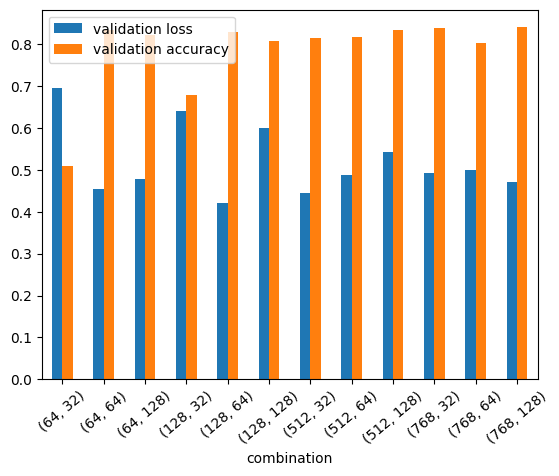

In [ ]:
plt.figure(figsize=(10, 10))
hyperparam_df.set_index("combination").plot.bar()
plt.xticks(rotation=40)
plt.show()

In [ ]:
hyperparam_df.loc[hyperparam_df['validation accuracy'] == hyperparam_df['validation accuracy'].max()]

,combination,validation loss,validation accuracy
11,"(768, 128)",0.471817,0.840596


As we can see, the optimal hyperparameter achieving the best validation accuracy are: **768** and **128** for `embedding_dim` and `hidden_dim` respectievly.

### 4.1.3 Training a Model with Optimal Hyperparameters

In [ ]:
optimal_embedding_dim = 768
optimal_hidden_dim = 128
lstm_model = create_lstm_model(optimal_embedding_dim, optimal_hidden_dim)
history = lstm_model.fit(train_padded_sequences, df_train["label"], epochs=num_epochs,
                    batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))

Epoch 1/5
2105/2105 [==============================] - 40s 17ms/step - loss: 0.6872 - accuracy: 0.5574 - val_loss: 0.6971 - val_accuracy: 0.5092
Epoch 2/5
2105/2105 [==============================] - 17s 8ms/step - loss: 0.6242 - accuracy: 0.6180 - val_loss: 0.4256 - val_accuracy: 0.8222
Epoch 3/5
2105/2105 [==============================] - 16s 8ms/step - loss: 0.2313 - accuracy: 0.9121 - val_loss: 0.3686 - val_accuracy: 0.8509
Epoch 4/5
2105/2105 [==============================] - 16s 8ms/step - loss: 0.1246 - accuracy: 0.9534 - val_loss: 0.4494 - val_accuracy: 0.8463
Epoch 5/5
2105/2105 [==============================] - 16s 7ms/step - loss: 0.0841 - accuracy: 0.9687 - val_loss: 0.4555 - val_accuracy: 0.8475


### 4.1.4 Model Results

In [ ]:
def plot_loss(history, model_type):
    """
    Plot training and validation loss curves for a Keras model.

    Parameters
    ----------
    - history : keras.callbacks.History
        The training history of a Keras model.

    - model_type : str
        A string indicating the type or name of the model.
    """

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training Loss Vs. Validation Loss " + model_type)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_accuracy(history, model_type):
    """
    Plot training and validation accuracy curves for a Keras model.

    Parameters
    ----------
    - history : keras.callbacks.History
        The training history of a Keras model.

    - model_type : str
        A string indicating the type or name of the model.
    """

    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training Accuracy Vs. Validation Accuracy " + model_type)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_confusion_matrix(y_preds, y_true, labels, model_type):
    """
    Plot a normalized confusion matrix for classification results.

    Parameters
    ----------
    - y_preds : array-like of shape (n_samples,)
        Predicted labels.

    - y_true : array-like of shape (n_samples,)
        True labels.

    - labels : list
        List of class labels.

    - model_type : str
        A string indicating the type or name of the model.
    """

    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix " + model_type)
    plt.show()


def print_classification_report(y_preds, y_true):
    """
    Display classification report for classification results.

    Parameters
    ----------
    - y_preds : array-like of shape (n_samples,)
        Predicted labels.

    - y_true : array-like of shape (n_samples,)
        True labels.
    """

    clf = classification_report(y_true, y_preds)
    print(clf)

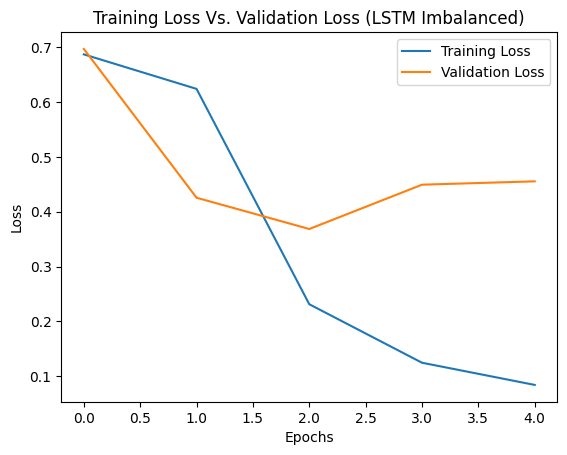

In [ ]:
plot_loss(history, "(LSTM Imbalanced)")

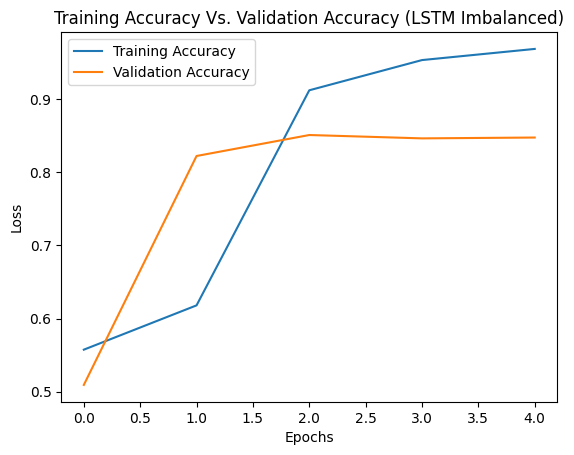

In [ ]:
plot_accuracy(history, "(LSTM Imbalanced)")

28/28 [==============================] - 0s 3ms/step


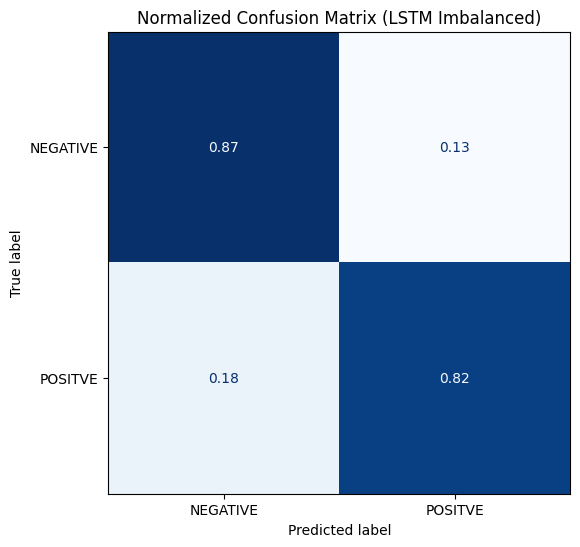

In [ ]:
y_pred = lstm_model.predict(valid_padded_sequences).argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(LSTM Imbalanced)")

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       428
           1       0.87      0.82      0.85       444

    accuracy                           0.85       872
   macro avg       0.85      0.85      0.85       872
weighted avg       0.85      0.85      0.85       872



### 4.1.5 Model Testing

In [ ]:
val_loss, val_accuracy = lstm_model.evaluate(valid_padded_sequences, df_validation['label'])
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 [==============================] - 0s 4ms/step - loss: 0.4555 - accuracy: 0.8475
Validation Loss: 0.4555 | Validation Accuracy: 84.75%


In [ ]:
def predict(model, tokenizer, text):
    """
    Predict sentiment label and score for a given text using a Keras `model`.

    Parameters
    ----------
    - model : keras.Model
        The trained Keras model for sentiment analysis.

    - tokenizer : keras.preprocessing.text.Tokenizer
        The tokenizer used for preprocessing the text.

    - text : str
        The input text for sentiment prediction.

    Returns
    -------
    dict
        A dictionary containing the predicted sentiment label and score.
        Example: {"label": "POSITIVE", "score": 0.85}
    """

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)

    label = "POSITIVE" if prediction.argmax() else "NEGATIVE"
    score = prediction[0, 1] if prediction.argmax() else prediction[0, 0]

    return {"label": label, "score": score}

In [ ]:
test_cases = [
    {"text": "I love you", "label": "POSITIVE"},
    {"text": "I hate you", "label": "NEGATIVE"},
    {"text": "I hate the selfishness in you", "label": "NEGATIVE"},
    {"text": "I hate anyone hurts you", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you, you are my partner", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you, you are my love", "label": "POSITIVE"},
    {"text": "I like rude people", "label": "NEGATIVE"},
    {"text": "I don't like rude people", "label": "POSITIVE"},
    {"text": "I hate polite people", "label": "NEGATIVE"},
    {"text": "I don't hate polite people", "label": "POSITIVE"},
]

test_cases_df = pd.DataFrame(test_cases)
test_cases_df

,text,label
0,I love you,POSITIVE
1,I hate you,NEGATIVE
2,I hate the selfishness in you,NEGATIVE
3,I hate anyone hurts you,POSITIVE
4,I hate anyone hurting you,POSITIVE
5,"I hate anyone hurting you, you are my partner",POSITIVE
6,"I hate anyone hurting you, you are my love",POSITIVE
7,I like rude people,NEGATIVE
8,I don't like rude people,POSITIVE
9,I hate polite people,NEGATIVE


In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    prediction = predict(lstm_model, tokenizer, row[0])
    predicted_labels.append(prediction["label"])
    predicted_scores.append(prediction["score"])

test_cases_df["lstm_predicted_label"] = predicted_labels
test_cases_df["lstm_predicted_score"] = predicted_scores
test_cases_df

1/1 [==============================] - 0s 21ms/step


,text,label,lstm_predicted_label,lstm_predicted_score
0,I love you,POSITIVE,POSITIVE,0.997406
1,I hate you,NEGATIVE,NEGATIVE,0.988617
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.988964
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.994716
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.995313
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.988686
6,"I hate anyone hurting you, you are my love",POSITIVE,NEGATIVE,0.646798
7,I like rude people,NEGATIVE,NEGATIVE,0.980396
8,I don't like rude people,POSITIVE,NEGATIVE,0.980396
9,I hate polite people,NEGATIVE,NEGATIVE,0.987814


### 4.1.6 Conclusion
The provided analysis reveals the model's strong performance on straightforward sentences such as **"I love you"** and **"I hate the selfishness in you"** However, its effectiveness diminishes in other test cases, primarily due to the constraints of **fixed embeddings**. In this scenario, each token's influence remains **isolated from others**, impacting the model's overall understanding.

**A notable observation** pertains to the sentence **"I hate anyone hurting you, you are my love"** Despite an incorrect label, the model exhibits a **relatively lower confidence score**. This suggests the model's attempt to refine its comprehension by incorporating supplementary elements, such as **"you are my love"** in an effort to gain a more nuanced understanding of the sentence.

## 4.2 Fixed-Embeddings LSTM Model (Balanced)

### 4.2.1 Balancing the Dataset
To enhance **simplicity** and **coherence**, I opted for downsampling the majority class (`positive`). This choice was made as traditional oversampling techniques in Natural Language Processing (NLP) typically involve employing advanced data augmentation methods, which can introduce complexity beyond the scope of the current context.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X = train_padded_sequences
y = df_train["label"]
print(f"Original label counts:\n{Counter(y)}\n")

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print(f"Oversampled label counts:\n{Counter(y_res)}\n")

Original label counts:
Counter({1: 37569, 0: 29780})

Oversampled label counts:
Counter({0: 29780, 1: 29780})



### 4.2.2 Training the Model with Optimal Hyperparameters

In [ ]:
model_balanced_ds = create_lstm_model(optimal_embedding_dim, optimal_hidden_dim)
history = model_balanced_ds.fit(X_res, y_res, epochs=num_epochs,
                    batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))

Epoch 1/5
1862/1862 [==============================] - 37s 19ms/step - loss: 0.6937 - accuracy: 0.4952 - val_loss: 0.6940 - val_accuracy: 0.4908
Epoch 2/5
1862/1862 [==============================] - 15s 8ms/step - loss: 0.6633 - accuracy: 0.5516 - val_loss: 0.5265 - val_accuracy: 0.7603
Epoch 3/5
1862/1862 [==============================] - 15s 8ms/step - loss: 0.2739 - accuracy: 0.8934 - val_loss: 0.4111 - val_accuracy: 0.8165
Epoch 4/5
1862/1862 [==============================] - 14s 8ms/step - loss: 0.1438 - accuracy: 0.9475 - val_loss: 0.4527 - val_accuracy: 0.8177
Epoch 5/5
1862/1862 [==============================] - 14s 7ms/step - loss: 0.0957 - accuracy: 0.9644 - val_loss: 0.4484 - val_accuracy: 0.8268


### 4.2.3 Model Results

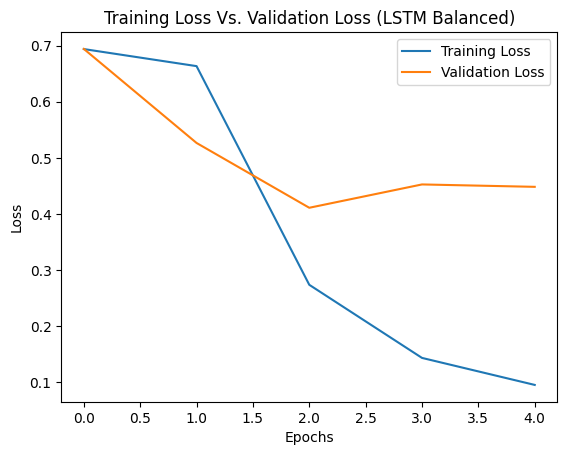

In [ ]:
plot_loss(history, "(LSTM Balanced)")

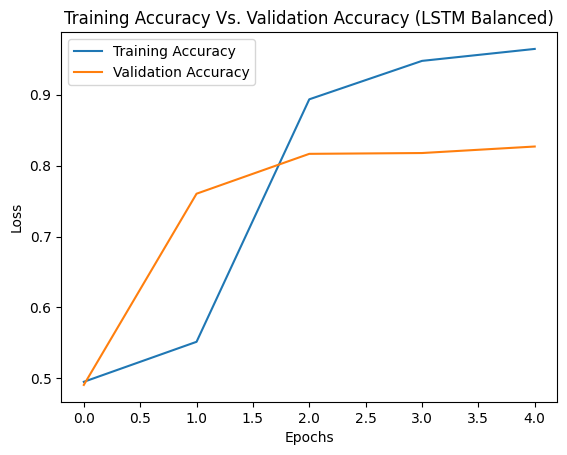

In [ ]:
plot_accuracy(history, "(LSTM Balanced)")

28/28 [==============================] - 0s 3ms/step


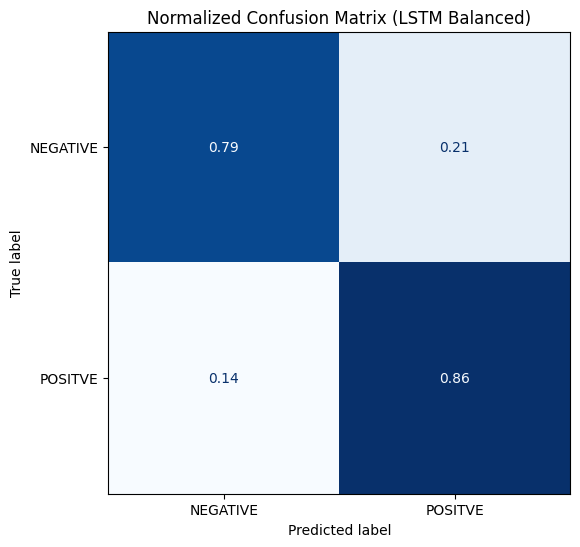

In [ ]:
y_pred = model_balanced_ds.predict(valid_padded_sequences).argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(LSTM Balanced)")

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       428
           1       0.81      0.86      0.83       444

    accuracy                           0.83       872
   macro avg       0.83      0.83      0.83       872
weighted avg       0.83      0.83      0.83       872



### 4.2.4 Model Testing

In [ ]:
val_loss, val_accuracy = model_balanced_ds.evaluate(valid_padded_sequences, df_validation['label'])
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 [==============================] - 0s 4ms/step - loss: 0.4484 - accuracy: 0.8268
Validation Loss: 0.4484 | Validation Accuracy: 82.68%


In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    prediction = predict(model_balanced_ds, tokenizer, row[0])
    predicted_labels.append(prediction["label"])
    predicted_scores.append(prediction["score"])

test_cases_df["predicted_label_balanced"] = predicted_labels
test_cases_df["predicted_score_balanced"] = predicted_scores
test_cases_df

1/1 [==============================] - 0s 19ms/step


,text,label,lstm_predicted_label,lstm_predicted_score,predicted_label_balanced,predicted_score_balanced
0,I love you,POSITIVE,POSITIVE,0.997406,POSITIVE,0.993450
1,I hate you,NEGATIVE,NEGATIVE,0.988617,NEGATIVE,0.931653
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.988964,NEGATIVE,0.959181
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.994716,NEGATIVE,0.998690
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.995313,NEGATIVE,0.989341
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.988686,NEGATIVE,0.870283
6,"I hate anyone hurting you, you are my love",POSITIVE,NEGATIVE,0.646798,NEGATIVE,0.905727
7,I like rude people,NEGATIVE,NEGATIVE,0.980396,NEGATIVE,0.988417
8,I don't like rude people,POSITIVE,NEGATIVE,0.980396,NEGATIVE,0.988417
9,I hate polite people,NEGATIVE,NEGATIVE,0.987814,NEGATIVE,0.994646


### 4.2.5 Conclusion
Surprisengly, there is no improvement in performance; in fact, it tends to degrade compared to the imbalanced dataset. This degradation arises from **the removal of data points from the majority class**, potentially leading the model to exhibit a stronger bias towards that class and consequently achieving a higher accuracy. Notably, the sentence **"I hate anyone hurting you, you are my love"** exemplifies this concern: in the imbalanced model, it yielded a confidence score of 0.64, but under downsampling, this score significantly surged to around **0.90**. This unsettling shift underscores the magnitude of the issue resulting from the data removal incurred during the undersampling process.

So, we can see that using fixed embeddings is good for relatively simple sentences, but it's **not perfect** and doesn't solve our problem at all. Is there a better way? Thankfully, **transformers with self-attention** can help. They improve fixed embeddings by **capturing information from the entire sentence**, allowing the model to **better understand the overall context**.

## 4.3 Contextual-Embeddings `DistilBERT` Model

In [ ]:
# we need to reset format of the dataset as we change it to pandas above
dataset.reset_format()

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

### 4.3.1 Loading `DistilBERT` Tokenizer and Model
The decision of choosing `DistilBERT` over traditional `BERT` instances from the task's inherent simplicity, aiming for enhanced efficiency. This choice is rooted in the fact that `DistilBERT` offers a **40%** reduction in **memory requirements** (**67** million parameters) compared to the standard BERT base (**110** million parameters), all while maintaining a relatively high level of performance. This strategic selection aligns with the task's straightforward nature, capitalizing on the efficiency gains achieved by leveraging a more lightweight yet effective model in the form of `DistilBERT`.

In [ ]:
model_ckpt = "distilbert-base-cased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=labels.num_classes)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### 4.3.2 Dataset Tokenizing

In [ ]:
def tokenize(batch, tokenizer):
    """
    Tokenize a batch of sentences using a given `tokenizer`.

    Parameters
    ----------
    - batch : dict
        A dictionary containing a key 'sentence' with a list of sentences.

    - tokenizer : transformers.AutoTokenizer
        The tokenizer used for tokenization.

    Returns
    -------
    dict
        A dictionary containing the tokenized sequences with padding and truncation.
    """

    return tokenizer(batch["sentence"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None, fn_kwargs={"tokenizer": distilbert_tokenizer})

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
print(f"Dataset after encoding:")
print(dataset_encoded)

Dataset after encoding:
DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


### 4.3.3 Converting Hugging Face `Dataset` object to `TF.Dataset`

In [ ]:
# Choose only the ['input_ids', 'attention_mask']
tokenizer_columns = distilbert_tokenizer.model_input_names

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)

tf_valid_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


### 4.3.4 Model Compiling

In [ ]:
distilbert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

### 4.3.5 Model Fine-Tuning

In [ ]:
history = distilbert_model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=3)

Epoch 1/3
2105/2105 [==============================] - 503s 228ms/step - loss: 0.2430 - accuracy: 0.9009 - val_loss: 0.2497 - val_accuracy: 0.9071
Epoch 2/3
2105/2105 [==============================] - 465s 221ms/step - loss: 0.1355 - accuracy: 0.9509 - val_loss: 0.2899 - val_accuracy: 0.9025
Epoch 3/3
2105/2105 [==============================] - 466s 221ms/step - loss: 0.0976 - accuracy: 0.9651 - val_loss: 0.2945 - val_accuracy: 0.9048


### 4.3.6 Model Results

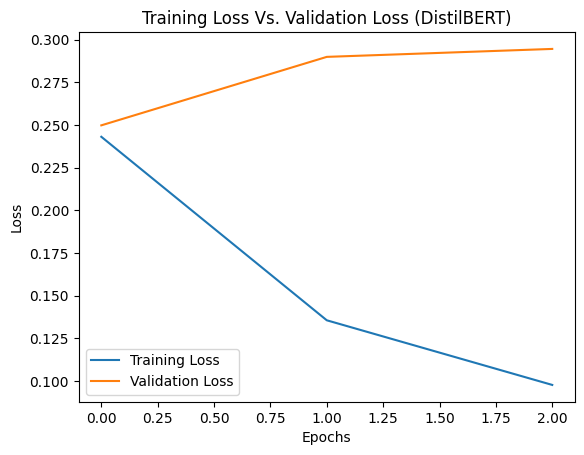

In [ ]:
plot_loss(history, "(DistilBERT)")

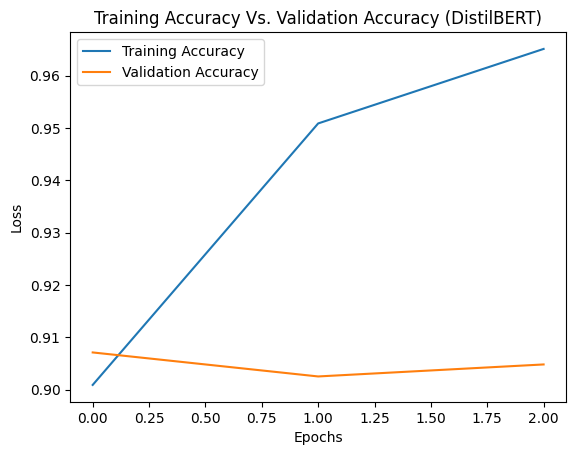

In [ ]:
plot_accuracy(history, "(DistilBERT)")

28/28 [==============================] - 3s 66ms/step


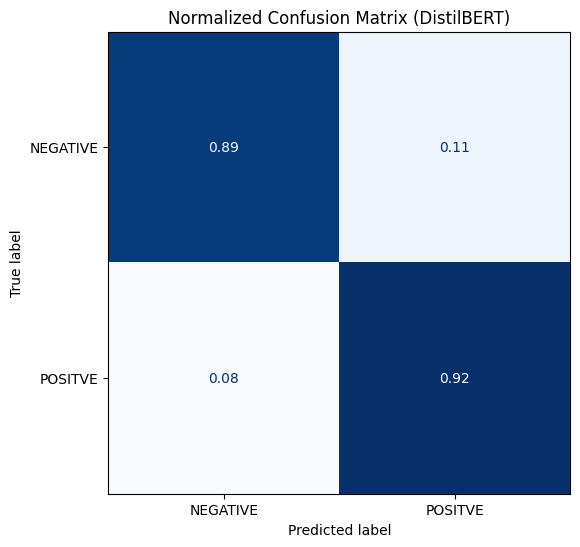

In [ ]:
y_pred = distilbert_model.predict(tf_valid_dataset).logits.argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(DistilBERT)")

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       428
           1       0.89      0.92      0.91       444

    accuracy                           0.90       872
   macro avg       0.91      0.90      0.90       872
weighted avg       0.91      0.90      0.90       872



### 4.3.7 Model Testing

In [ ]:
val_loss, val_accuracy = distilbert_model.evaluate(tf_valid_dataset)
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 [==============================] - 2s 68ms/step - loss: 0.2945 - accuracy: 0.9048
Validation Loss: 0.2945 | Validation Accuracy: 90.48%


In [ ]:
def softmax(x):
    """
    Compute softmax values for a set of scores.

    Parameters
    ----------
    - x : numpy.ndarray
        Array containing the input scores.

    Returns
    -------
    numpy.ndarray
        Array containing the softmax values.
    """
    
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    inputs = distilbert_tokenizer(row[0], padding=True, truncation=True)
    logits = distilbert_model.predict(inputs["input_ids"]).logits
    scores = softmax(logits[0])

    label = "POSITIVE" if scores.argmax() else "NEGATIVE"
    score = scores[1] if scores.argmax() else scores[0]

    predicted_labels.append(label)
    predicted_scores.append(score)

test_cases_df["predicted_label_distilbert"] = predicted_labels
test_cases_df["predicted_score_distilbert"] = predicted_scores
test_cases_df

1/1 [==============================] - 0s 44ms/step


,text,label,lstm_predicted_label,lstm_predicted_score,predicted_label_balanced,predicted_score_balanced,predicted_label_distilbert,predicted_score_distilbert
0,I love you,POSITIVE,POSITIVE,0.997406,POSITIVE,0.993450,POSITIVE,0.998754
1,I hate you,NEGATIVE,NEGATIVE,0.988617,NEGATIVE,0.931653,NEGATIVE,0.984097
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.988964,NEGATIVE,0.959181,NEGATIVE,0.985653
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.994716,NEGATIVE,0.998690,POSITIVE,0.910951
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.995313,NEGATIVE,0.989341,NEGATIVE,0.510459
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.988686,NEGATIVE,0.870283,POSITIVE,0.997720
6,"I hate anyone hurting you, you are my love",POSITIVE,NEGATIVE,0.646798,NEGATIVE,0.905727,POSITIVE,0.997089
7,I like rude people,NEGATIVE,NEGATIVE,0.980396,NEGATIVE,0.988417,NEGATIVE,0.969281
8,I don't like rude people,POSITIVE,NEGATIVE,0.980396,NEGATIVE,0.988417,POSITIVE,0.821191
9,I hate polite people,NEGATIVE,NEGATIVE,0.987814,NEGATIVE,0.994646,NEGATIVE,0.994681


### 4.3.8 Conclusion
When we compare using fixed embeddings (like LSTM) to using contextualized embeddings (like DistilBERT), we notice a big difference. With DistilBERT, after training for only three epochs on the validation set, I achieve around **91%** accuracy.

Looking at a specific test case, it's clear that the model handles words with multiple meanings quite well. The only mistake was classifying **"I hate anyone hurting you"** as `NEGATIVE`. However, it's interesting to see that the model gave it a low confidence score of about **51%**. This means the model is smart enough to say there's about a **49%** chance that this sample could be `POSITIVE`, showing its ability to make nuanced decisions.

# 5.0 Final Conclusion
Ultimately, the decision to opt for fixed embeddings models or contextualized embeddings hinges on the nature of the data the model will encounter in real-world scenarios. When dealing with straightforward data, fixed embeddings might suffice, offering good performance while requiring less memory compared to transformer-based models. However, in cases where the data is more complex, as demonstrated in our test cases, leveraging a transformer-based model with a self-attention mechanism can yield substantial performance improvements. It's crucial to note that this advantage comes at the expense of a higher memory footprint.